# **Importación de Librerías y Configuración de GPU**

In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet_v2 import ResNet50V2, preprocess_input
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense, Input, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import mixed_precision
import matplotlib.pyplot as plt
import pickle
import os

# --- OPTIMIZACIÓN DE HARDWARE (GRAFICA RTX 4060) ---
try:
    mixed_precision.set_global_policy('mixed_float16')
except Exception as e:
    print(f"[INFO] Advertencia: No se pudo activar Mixed Precision. Error: {e}")

# Verificar disponibilidad de GPU
print(f"[INFO] GPUs Disponibles: {len(tf.config.list_physical_devices('GPU'))}")

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 4060, compute capability 8.9
[INFO] GPUs Disponibles: 1


# **Configuración de Rutas y Parámetros**

In [2]:
# --- CONFIGURACIÓN ---
dataset_path = r"E:\Documentos\7mo Semestre\Inteligencia Artificial\Python\Reconocedor de rostros\FamososMini"

model_save_path = "modelo_facial_resnet_turbo.h5"
label_save_path = "etiquetas.pickle"
plot_save_path = "grafica_entrenamiento.png"

BS = 64
EPOCHS_1 = 20 # Fase calentamiento
EPOCHS_2 = 20 # Fase precisión
IMG_SIZE = (224, 224) # Tamaño estándar para ResNet

# **Generadores de Datos (Data Augmentation)**

In [3]:
# --- GENERADORES DE DATOS (CON VALIDACIÓN) ---
aug = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest",
    preprocessing_function=preprocess_input,
    validation_split=0.20 # 20% para validación
)

print("[INFO] Generando datos de ENTRENAMIENTO...")
train_generator = aug.flow_from_directory(
    dataset_path,
    target_size=IMG_SIZE,
    batch_size=BS,
    class_mode="categorical",
    subset="training",
    shuffle=True
)

print("[INFO] Generando datos de VALIDACIÓN...")
valid_generator = aug.flow_from_directory(
    dataset_path,
    target_size=IMG_SIZE,
    batch_size=BS,
    class_mode="categorical",
    subset="validation",
    shuffle=False
)

# Guardar etiquetas inmediatamente para referencia
class_names = train_generator.class_indices
print(f"[INFO] Clases detectadas: {class_names}")
with open(label_save_path, "wb") as f:
    pickle.dump(class_names, f)
print("[INFO] Etiquetas guardadas exitosamente.")

[INFO] Generando datos de ENTRENAMIENTO...
Found 1444 images belonging to 14 classes.
[INFO] Generando datos de VALIDACIÓN...
Found 355 images belonging to 14 classes.
[INFO] Clases detectadas: {'Angelina Jolie': 0, 'Denzel Washington': 1, 'Hugh Jackman': 2, 'Johnny Depp': 3, 'Jose Gastelum': 4, 'Kate Winslet': 5, 'Nicole Kidman': 6, 'Oscar Santacruz': 7, 'Robert Downey Jr': 8, 'Said Rodriguez': 9, 'Scarlett Johansson': 10, 'Tom Hanks': 11, 'Will Smith': 12, 'Z_Desconocidos': 13}
[INFO] Etiquetas guardadas exitosamente.


# **Construcción del Modelo (Transfer Learning)**

In [4]:
# --- ARQUITECTURA DEL MODELO ---
print("[INFO] Construyendo ResNet50V2...")

# Base del modelo (pre-entrenado en ImageNet)
baseModel = ResNet50V2(weights="imagenet", include_top=False,
                       input_tensor=Input(shape=(224, 224, 3)))

# Fase 1: Congelar todo el esqueleto para no destruir pesos previos
baseModel.trainable = False

# Crear la nueva cabeza (Top Head)
headModel = baseModel.output
headModel = GlobalAveragePooling2D()(headModel)
headModel = BatchNormalization()(headModel) # Estabilidad
headModel = Dense(512, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel) # Reduce overfitting

# Salida softmax
headModel = Dense(len(class_names), activation="softmax", dtype='float32')(headModel)

# Unir base y cabeza
model = Model(inputs=baseModel.input, outputs=headModel)
model.summary()

[INFO] Construyendo ResNet50V2...
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                            

# **Entrenamiento Fase 1 (Calentamiento)**

In [5]:
# --- FASE 1: CALENTAMIENTO ---
print(f"\n--- FASE 1: Calentamiento (Batch Size: {BS}) ---")

opt = Adam(learning_rate=1e-3)

model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

H1 = model.fit(
    train_generator,
    epochs=EPOCHS_1,
    validation_data=valid_generator,
    verbose=1,
    workers=6,
    use_multiprocessing=False
)


--- FASE 1: Calentamiento (Batch Size: 64) ---
Epoch 1/20
23/23 [==============================] - 27s 349ms/step - loss: 1.5427 - accuracy: 0.5506 - val_loss: 0.9815 - val_accuracy: 0.6704
Epoch 2/20
23/23 [==============================] - 4s 148ms/step - loss: 0.7300 - accuracy: 0.7583 - val_loss: 0.6466 - val_accuracy: 0.8000
Epoch 3/20
23/23 [==============================] - 4s 150ms/step - loss: 0.5941 - accuracy: 0.7978 - val_loss: 0.5470 - val_accuracy: 0.8366
Epoch 4/20
23/23 [==============================] - 4s 155ms/step - loss: 0.4994 - accuracy: 0.8289 - val_loss: 0.5062 - val_accuracy: 0.8197
Epoch 5/20
23/23 [==============================] - 4s 151ms/step - loss: 0.3811 - accuracy: 0.8753 - val_loss: 0.3936 - val_accuracy: 0.8817
Epoch 6/20
23/23 [==============================] - 4s 149ms/step - loss: 0.3912 - accuracy: 0.8636 - val_loss: 0.3751 - val_accuracy: 0.8648
Epoch 7/20
23/23 [==============================] - 4s 150ms/step - loss: 0.3993 - accuracy: 0.8670

# **Entrenamiento Fase 2 (Fine Tuning)**

In [6]:
# --- FASE 2: FINE TUNING (PROFUNDO) ---
print("\n--- FASE 2: Ajuste Fino (Mejorando Accuracy) ---")

baseModel.trainable = True

for layer in baseModel.layers[:140]:
    layer.trainable = False

for layer in baseModel.layers:
    if isinstance(layer, BatchNormalization):
        layer.trainable = False

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=4, min_lr=1e-7, verbose=1)
early_stop = EarlyStopping(monitor='val_loss', patience=25, restore_best_weights=True)

opt_fine = Adam(learning_rate=1e-5)

model.compile(loss="categorical_crossentropy", optimizer=opt_fine, metrics=["accuracy"])

H2 = model.fit(
    train_generator,
    epochs=EPOCHS_2,
    validation_data=valid_generator,
    callbacks=[reduce_lr, early_stop],
    verbose=1,
    workers=6,
    use_multiprocessing=False
)


--- FASE 2: Ajuste Fino (Mejorando Accuracy) ---
Epoch 1/20
23/23 [==============================] - 10s 229ms/step - loss: 0.1665 - accuracy: 0.9460 - val_loss: 0.1771 - val_accuracy: 0.9296 - lr: 1.0000e-05
Epoch 2/20
23/23 [==============================] - 4s 161ms/step - loss: 0.1504 - accuracy: 0.9460 - val_loss: 0.1513 - val_accuracy: 0.9352 - lr: 1.0000e-05
Epoch 3/20
23/23 [==============================] - 4s 155ms/step - loss: 0.1259 - accuracy: 0.9536 - val_loss: 0.1848 - val_accuracy: 0.9493 - lr: 1.0000e-05
Epoch 4/20
23/23 [==============================] - 4s 161ms/step - loss: 0.1153 - accuracy: 0.9598 - val_loss: 0.1160 - val_accuracy: 0.9577 - lr: 1.0000e-05
Epoch 5/20
23/23 [==============================] - 4s 155ms/step - loss: 0.1020 - accuracy: 0.9647 - val_loss: 0.1454 - val_accuracy: 0.9634 - lr: 1.0000e-05
Epoch 6/20
23/23 [==============================] - 4s 157ms/step - loss: 0.0753 - accuracy: 0.9751 - val_loss: 0.1289 - val_accuracy: 0.9577 - lr: 1.0000

# **Guardado y Visualización de Resultados**

[INFO] Guardando modelo en modelo_facial_resnet_turbo.h5...


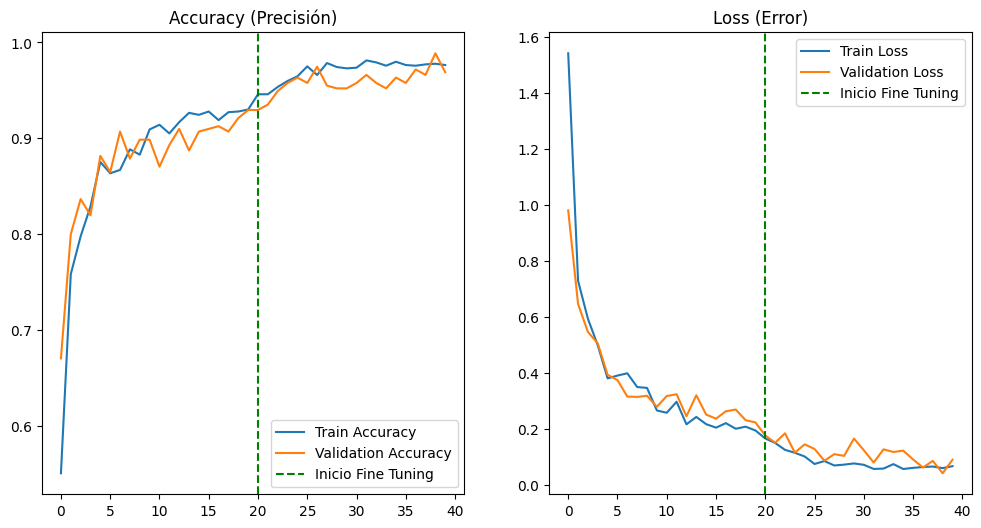

[INFO] Gráfica guardada y mostrada.
¡PROCESO TERMINADO EXITOSAMENTE!


In [7]:
# --- GUARDAR Y GRAFICAR ---
print(f"[INFO] Guardando modelo en {model_save_path}...")
model.save(model_save_path)

# Concatenar historiales de H1 y H2
acc = H1.history['accuracy'] + H2.history['accuracy']
val_acc = H1.history['val_accuracy'] + H2.history['val_accuracy']
loss = H1.history['loss'] + H2.history['loss']
val_loss = H1.history['val_loss'] + H2.history['val_loss']

# Crear gráfica
plt.figure(figsize=(12, 6))

# Gráfica de Precisión
plt.subplot(1, 2, 1)
plt.plot(acc, label='Train Accuracy')
plt.plot(val_acc, label='Validation Accuracy')

# Línea vertical para indicar dónde empezó el Fine Tuning
plt.axvline(x=EPOCHS_1, color='green', linestyle='--', label='Inicio Fine Tuning')
plt.legend(loc='lower right')
plt.title('Accuracy (Precisión)')

# Gráfica de Pérdida (Loss)
plt.subplot(1, 2, 2)
plt.plot(loss, label='Train Loss')
plt.plot(val_loss, label='Validation Loss')
plt.axvline(x=EPOCHS_1, color='green', linestyle='--', label='Inicio Fine Tuning')
plt.legend(loc='upper right')
plt.title('Loss (Error)')

plt.savefig(plot_save_path)
plt.show()

print(f"[INFO] Gráfica guardada y mostrada.")
print("¡PROCESO TERMINADO EXITOSAMENTE!")